In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, Rescaling, Resizing, MaxPooling2D, Conv2D, Normalization, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d yashvrdnjain/hotdognothotdog

Dataset URL: https://www.kaggle.com/datasets/yashvrdnjain/hotdognothotdog
License(s): CC0-1.0
 97% 161M/166M [00:03<00:00, 82.2MB/s]
100% 166M/166M [00:03<00:00, 57.7MB/s]


In [7]:
! unzip hotdognothotdog.zip

Archive:  hotdognothotdog.zip
  inflating: hotdog-nothotdog/test/hotdog/1501.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1502.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1503.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1504.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1505.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1506.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1507.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1508.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1509.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1510.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1511.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1512.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1513.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1514.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1515.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1516.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1517.jpg  
  inflating: hotdog-nothotdog/test/hotdog/1518.jpg  
  inflating: hot

In [11]:
batch_size = 25
img_size = (224, 224)

In [12]:
train_dataset = image_dataset_from_directory('/content/hotdog-nothotdog/train',
                                            subset = 'training',
                                            seed = 2003,
                                            validation_split =0.3,
                                            batch_size = batch_size,
                                            image_size = img_size)

Found 3000 files belonging to 2 classes.
Using 2100 files for training.


In [13]:
len(list(train_dataset))

84

In [14]:
validation_dataset = image_dataset_from_directory('/content/hotdog-nothotdog/train',
                                            subset = 'validation',
                                            seed = 2003,
                                            validation_split =0.3,
                                            batch_size = batch_size,
                                            image_size = img_size)

Found 3000 files belonging to 2 classes.
Using 900 files for validation.


In [15]:
class_names = train_dataset.class_names
class_names

['hotdog', 'nothotdog']

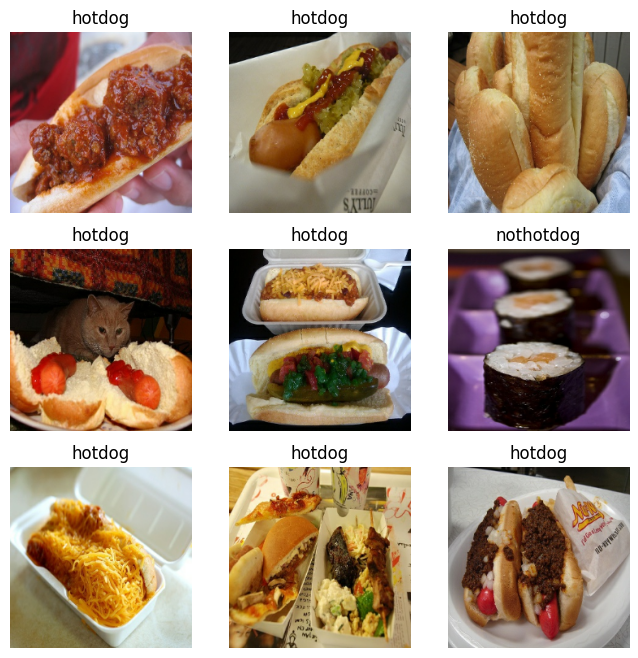

In [16]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range (9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
test_dataset = image_dataset_from_directory('/content/hotdog-nothotdog/test',
                                            batch_size = batch_size,
                                            image_size = img_size)

Found 644 files belonging to 2 classes.


In [18]:
IMG_SIZE = 224
def augment(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  if tf.random.uniform((), minval=0, maxval=1)<0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [ 1, 1, 1, 3]) #проблема в том что модель ожидает 3 канала на входе, а тут 1 \
                                                                    #и мы просто копируем его в канала
  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.random_contrast(image, lower=0.1, upper= 0.2)
  image = tf.image.random_flip_left_right(image) #50%

  return image, label


train_dataset = train_dataset.map(augment)
len(list(train_dataset))

84

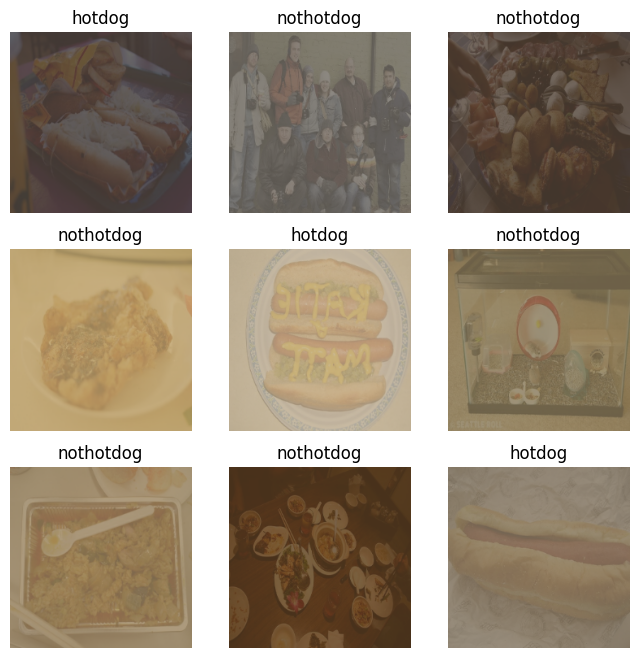

In [15]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range (9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

настройка производительности, предварительная загрузка нескольких минивыборок

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #автоматическая настройка

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [20]:
#последовательная модель
base_model = keras.applications.ResNet152(include_top=False, input_shape = (224, 224, 3), classes=2, weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 58381185 (222.71 MB)
Trainable params: 582

In [21]:

model.compile(loss="binary_crossentropy",
              optimizer='sgd',
              metrics=['accuracy'])


In [ ]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr*0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch+1, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)


history = model.fit(train_dataset,
                   validation_data = validation_dataset,
                   callbacks=[LearningRateReducerCb()],
                   epochs = 12,
                   verbose=2)

In [ ]:
scores = model.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 3s 258ms/step - loss: 0.2942 - accuracy: 0.9084


[0.29423409700393677, 0.9083850979804993]

In [ ]:
print ("Доля верных ответов на тестовых данных, в процентах:", round(scores[1]*100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.8385


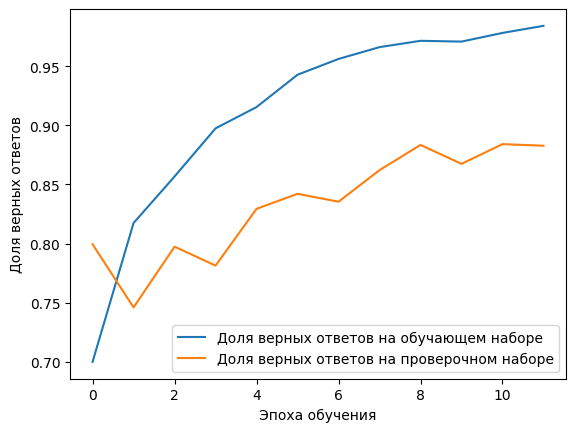

In [ ]:
plt.plot(history.history['accuracy'],
        label ='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
        label='Доля верных ответов на проверочном наборе')
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()

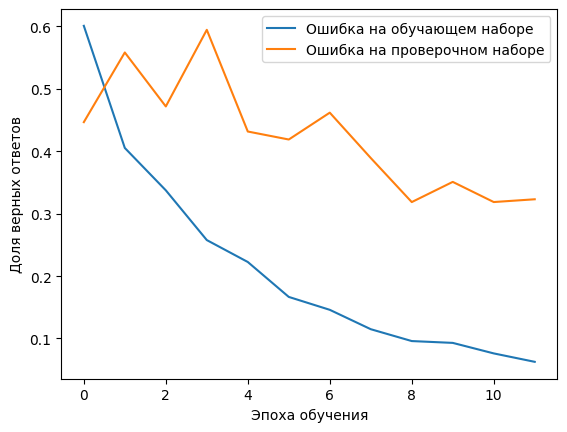

In [ ]:
plt.plot(history.history['loss'],
        label ='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
        label='Ошибка на проверочном наборе')
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()

In [ ]:
Predictions = model.predict(test_dataset)


7/7 [==============================] - 3s 279ms/step


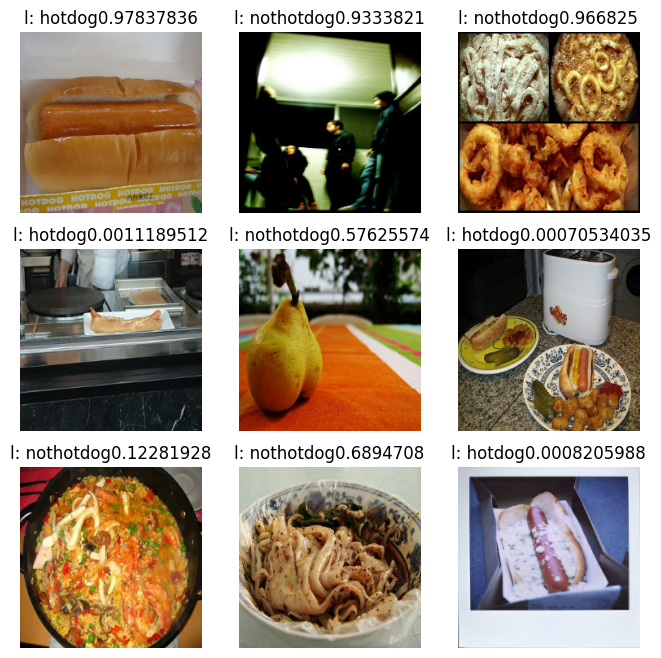

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range (9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("l: "+str(class_names[labels[i]])+str(Predictions[i][0]))
        plt.axis('off')
        #число - вероятность что не хот дог

In [ ]:
import cv2
from tensorflow.keras.utils import load_img, img_to_array
def download_and_predict(image_path):

    img = cv2.imread(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

    image = tf.keras.utils.load_img(image_path)
    image = image.resize((224, 224))

    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model.predict(input_arr)
    print(predictions[0][0])

    if predictions[0][0]<0.5:
        print("It's a Hot Dog!")
    else:
        print("It's not a hot dog :(")

1/1 [==============================] - 2s 2s/step
0.99967706
It's not a hot dog :(


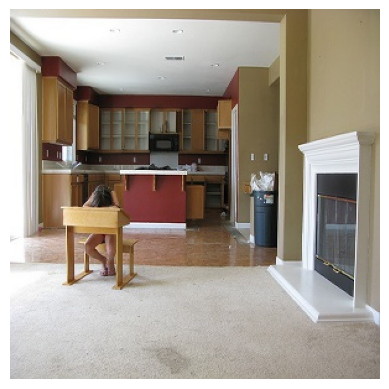

In [ ]:
download_and_predict("/content/hotdog-nothotdog/test/nothotdog/1572.jpg")

1/1 [==============================] - 0s 25ms/step
0.932035
It's not a hot dog :(


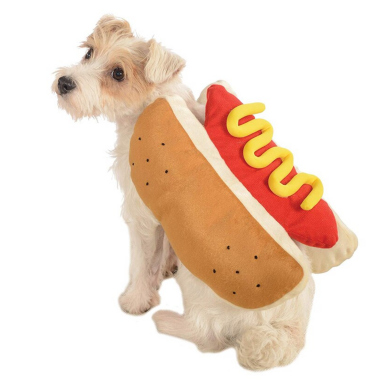

In [ ]:
download_and_predict("/content/-.jpg")

1/1 [==============================] - 0s 25ms/step
0.8779125
It's not a hot dog :(


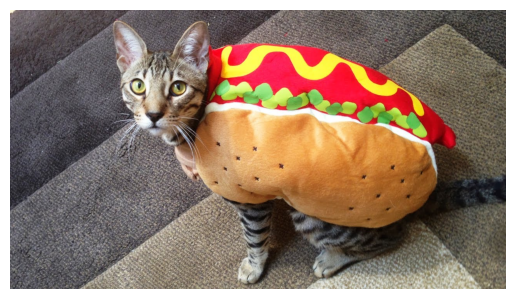

In [ ]:
download_and_predict("/content/maxresdefault.jpg")

1/1 [==============================] - 0s 28ms/step
0.92747694
It's not a hot dog :(


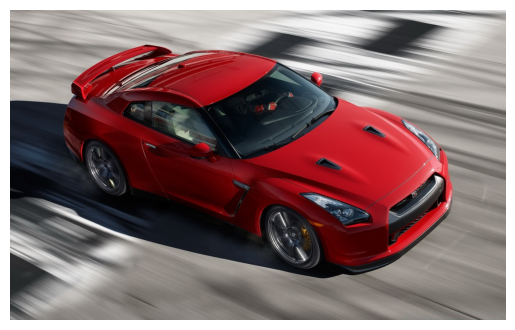

In [ ]:
download_and_predict("/content/bystraya-ezda-na-krasnoj-mashine-skorost.jpg")

1/1 [==============================] - 0s 26ms/step
0.9991399
It's not a hot dog :(


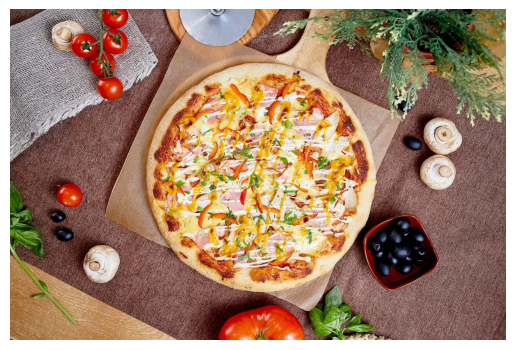

In [ ]:
download_and_predict("/content/1663680524_14-mykaleidoscope-ru-p-pitstsa-v-mikrovolnovke-yeda-krasivo-17.jpg")

1/1 [==============================] - 0s 26ms/step
0.0017504041
It's a Hot Dog!


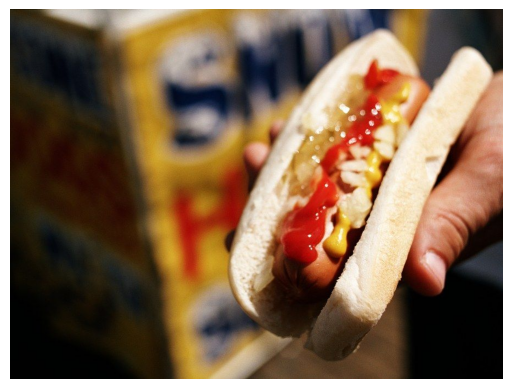

In [ ]:
download_and_predict("/content/7d502b918c7c28a5a2e3dd7f15deee05.jpg")

1/1 [==============================] - 0s 27ms/step
0.9984218
It's not a hot dog :(


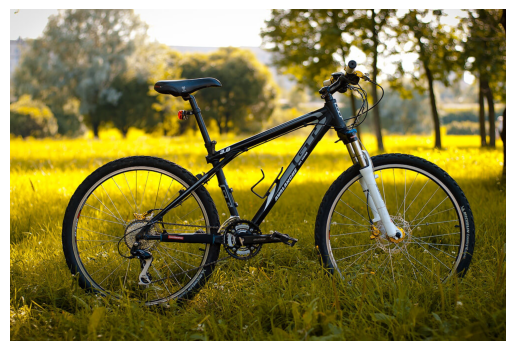

In [ ]:
download_and_predict("/content/gornii-velosiped-3.jpg")

1/1 [==============================] - 0s 27ms/step
0.16248041
It's a Hot Dog!


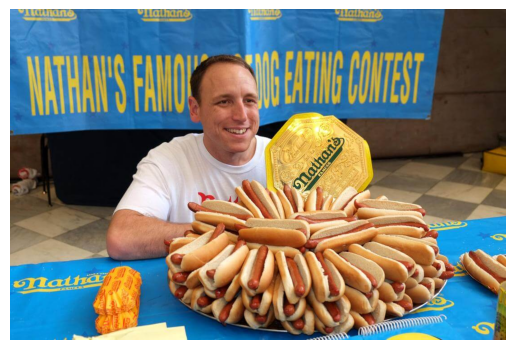

In [ ]:
download_and_predict("/content/hot-dog-05.jpg")

1/1 [==============================] - 0s 27ms/step
0.14074707
It's a Hot Dog!


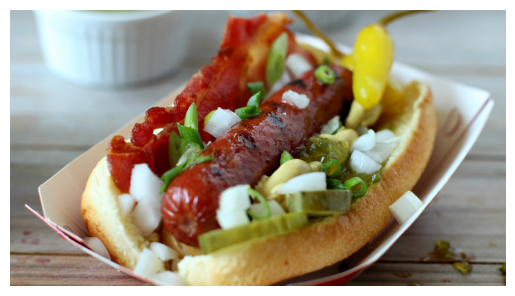

In [ ]:
download_and_predict("/content/hot-dog-and-slab-pie-019.jpg")

1/1 [==============================] - 0s 24ms/step
0.0019115411
It's a Hot Dog!


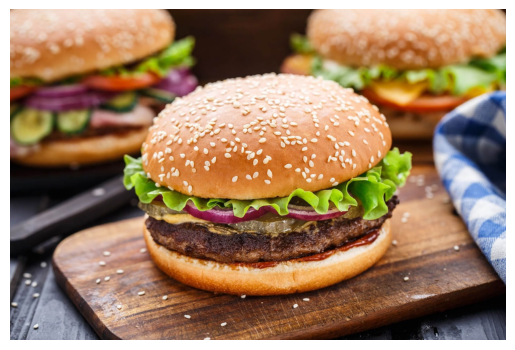

In [ ]:
download_and_predict("/content/imgpreview.jpg")

1/1 [==============================] - 0s 26ms/step
0.921435
It's not a hot dog :(


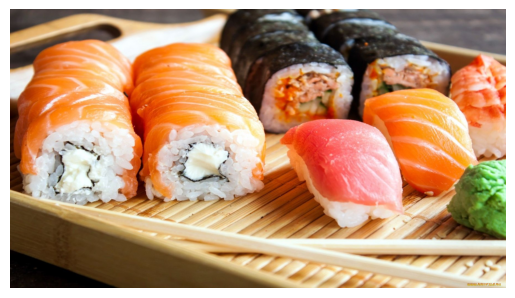

In [ ]:
download_and_predict("/content/kartinki-sushi-45.jpg")

1/1 [==============================] - 0s 24ms/step
0.0012198954
It's a Hot Dog!


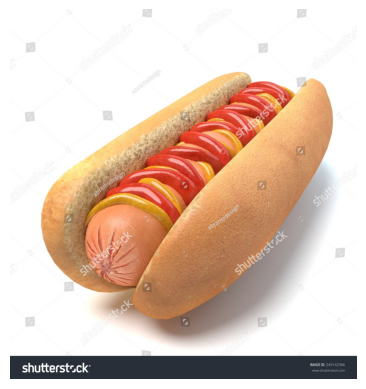

In [ ]:
download_and_predict("/content/stock-photo--d-illustration-of-a-hot-dog-249142366.jpg")